In [1]:
#!pip install pydot

In [2]:
#!apt update && apt install -y graphviz

In [3]:
import sys
sys.path.insert(0, '/tf/utils/')

In [4]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import tensorflow as tf
import matplotlib.pyplot as plt

In [5]:
from keras.models import Model, load_model
from keras.layers import multiply, Lambda, add, Activation, Dropout, Conv2DTranspose, ReLU, ZeroPadding2D, BatchNormalization, Input, Conv2D, Conv2DTranspose, Flatten, Dense, LeakyReLU, MaxPooling2D, UpSampling2D, Concatenate, concatenate
from keras.optimizers import Adam
import numpy as np
import tensorflow.keras.backend as K
import tensorflow as tf

from utils import calculate_snr, itakura_distortion, somar_sinais, add_white_gaussian_noise, performance
import librosa
from tqdm import tqdm

from sound import Sound

from IPython.display import Audio
import time
from IPython import display

from scipy.ndimage import zoom

In [6]:
import tensorflow as tf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [7]:
base_shape_size = 8192
ws = 255
ol = 128

In [8]:
sound_base = Sound('../../Dados/Base/', '../../Dados/ESC-50-master/audio/', base_shape_size)

Loading clean files: 100%|██████████| 50000/50000 [00:17<00:00, 2822.39it/s]


In [9]:
def calculate_stft_magnitude_and_phase(signal, sampling_rate=8000, window_size=ws, overlap=ol):
    # Calcula a STFT usando a biblioteca librosa
    stft_result = librosa.stft(signal, n_fft=window_size, hop_length=overlap)
    
    magnitude, phase = librosa.magphase(stft_result)
    phi = np.angle(phase)
    f = librosa.fft_frequencies(sr=sampling_rate, n_fft=window_size)
    t = librosa.frames_to_time(np.arange(stft_result.shape[1]), sr=sampling_rate, hop_length=overlap)

    return magnitude, phi, f, t

def reconstruct_signal_from_stft(magnitude, phi, sampling_rate=8000, window_size=ws, overlap=ol):
    # Reconstruct the signal from magnitude and phase
    complex_spec = magnitude * np.exp(1j * phi)
    signal = librosa.istft(complex_spec, hop_length=overlap)

    return signal

In [10]:
class DataGenerator:
    def __init__(self, sound_files, noise_files):
        self.sound_files = sound_files
        self.noise_files = noise_files

    def generate_sample_completo(self, batch_size=32):
        while True:
            # Carrega um lote de sons
            sound_batch_choices = np.random.choice(self.sound_files.shape[0], size=batch_size, replace=False)
            sound_batch = self.sound_files[sound_batch_choices]
            
            # Carrega um lote de ruídos
            noise_batch_choices = np.random.choice(self.noise_files.shape[0], size=batch_size, replace=False)
            noise_batch = self.noise_files[noise_batch_choices]
            
            x_train = []
            y_train = []
            
            # Adiciona ruído a cada som e calcula a nota PESQ
            for sound, noise in zip(sound_batch, noise_batch):
                # noisy_sound = somar_sinais(sound, noise, sr)
                try:
                    min_valor = np.min(sound)
                    max_valor = np.max(sound)
                    
                    # Defina o novo intervalo desejado
                    novo_min = -0.4
                    novo_max = 0.4
                    
                    # Realize a escala do sinal para o novo intervalo
                    sound_escalado = (sound - min_valor) / (max_valor - min_valor) * (novo_max - novo_min) + novo_min
    
                    sr = np.random.randint(0, 20, size=(1,)[0])
                    noisy_sound = somar_sinais(sound_escalado, noise, sr)
                    
                    # noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(20, 30, size=(1,)[0]))
                    noisy_sound = add_white_gaussian_noise(noisy_sound, np.random.randint(20, 30, size=(1,)[0]))
                    noisy_sound = np.clip(noisy_sound, -1.0, 1.0)
                    
                    A, phi, _, _ = calculate_stft_magnitude_and_phase(sound_escalado)
                    A_noisy, phi_noisy, _, _ = calculate_stft_magnitude_and_phase(noisy_sound)
    
                    # A /= NORM_FACTOR
                    # A_noisy /= NORM_FACTOR
    
                    # A = 10*np.log10(A)
                    # A_noisy = 10*np.log10(A_noisy)
    
                    # xA_batch.append(A)
                    # xphi_batch.append(phi)
                    # yA_batch.append(A_noisy)
                    # yphi_batch.append(phi_noisy)
                    
                    # Monta o fasor normalizando a faze por Pi
                    F = np.concatenate([A.reshape(A.shape[0], A.shape[1], 1), (phi.reshape(phi.shape[0], phi.shape[1], 1) / (2*np.pi)) + 0.5], axis=-1)
                    F_noisy = np.concatenate([A_noisy.reshape(A_noisy.shape[0], A_noisy.shape[1], 1), (phi_noisy.reshape(phi_noisy.shape[0], phi_noisy.shape[1], 1) / (2*np.pi)) + 0.5], axis=-1)
                    
                    # Adiciona o exemplo ao lote de treinamento
                    x_train.append(F_noisy)
                    y_train.append(F)
                except:
                    continue

            x_train = np.array(x_train)
            y_train = np.array(y_train)
            
            yield x_train, y_train

In [11]:
data_generator_train = DataGenerator(sound_base.train_X, sound_base.noise_sounds)
data_generator_val = DataGenerator(sound_base.val_X, sound_base.noise_sounds)

In [12]:
def downsample(filters, size, apply_batchnorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)

    result = tf.keras.Sequential()
    result.add(Conv2D(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

    if apply_batchnorm:
        result.add(BatchNormalization())

    result.add(LeakyReLU())
    
    return result

In [13]:
def upsample(filters, size, apply_dropout=False):
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(Conv2DTranspose(filters, size, strides=2, padding='same', kernel_initializer=initializer, use_bias=False))

  result.add(BatchNormalization())

  if apply_dropout:
      result.add(Dropout(0.5))

  result.add(ReLU())

  return result

In [14]:
# Tamanho da entrada
input_shape = (128, 64, 2)

# Função para criar o gerador
def Generator():
    inputs = Input(shape=input_shape)
    
    down_stack = [
    downsample(64, 4, apply_batchnorm=False),  # (batch_size, 128, 128, 64)
    downsample(128, 4),  # (batch_size, 64, 64, 128)
    downsample(256, 4),  # (batch_size, 32, 32, 256)
    downsample(512, 4),  # (batch_size, 16, 16, 512)
    downsample(512, 4),  # (batch_size, 8, 8, 512)
    # downsample(512, 4),  # (batch_size, 4, 4, 512)
    # downsample(512, 4),  # (batch_size, 2, 2, 512)
    # downsample(512, 4),  # (batch_size, 1, 1, 512)
    ]
    
    up_stack = [
    # upsample(512, 4, apply_dropout=True),  # (batch_size, 2, 2, 1024)
    # upsample(512, 4, apply_dropout=True),  # (batch_size, 4, 4, 1024)
    # upsample(512, 4, apply_dropout=True),  # (batch_size, 8, 8, 1024)
    upsample(512, 4),  # (batch_size, 16, 16, 1024)
    upsample(256, 4),  # (batch_size, 32, 32, 512)
    upsample(128, 4),  # (batch_size, 64, 64, 256)
    upsample(64, 4),  # (batch_size, 128, 128, 128)
    ]
    
    initializer = tf.random_normal_initializer(0., 0.02)
    last = Conv2DTranspose(2, 4,
                         strides=2,
                         padding='same',
                         kernel_initializer=initializer,
                         activation='linear')  # (batch_size, 256, 256, 3)
    
    x = inputs
    
    # Downsampling through the model
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)
        
    skips = reversed(skips[:-1])
    
    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = Concatenate()([x, skip])
    
    x = last(x)
    
    return Model(inputs=inputs, outputs=x)

# Função para criar o discriminador
def Discriminator():
    initializer = tf.random_normal_initializer(0., 0.02)
    
    inp = Input(shape=input_shape, name='input_image')
    tar = Input(shape=input_shape, name='target_image')
    
    x = concatenate([inp, tar])  # (batch_size, 256, 256, channels*2)
    
    down1 = downsample(64, 4, False)(x)  # (batch_size, 128, 128, 64)
    down2 = downsample(128, 4)(down1)  # (batch_size, 64, 64, 128)
    down3 = downsample(256, 4)(down2)  # (batch_size, 32, 32, 256)
    
    zero_pad1 = ZeroPadding2D()(down3)  # (batch_size, 34, 34, 256)
    conv = Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(zero_pad1) # (batch_size, 31, 31, 512)
    
    batchnorm1 = BatchNormalization()(conv)
    
    leaky_relu = LeakyReLU()(batchnorm1)
    
    zero_pad2 = ZeroPadding2D()(leaky_relu)  # (batch_size, 33, 33, 512)
    
    last = Conv2D(1, 4, strides=1, kernel_initializer=initializer)(zero_pad2)  # (batch_size, 30, 30, 1)
    
    return Model(inputs=[inp, tar], outputs=last)

In [15]:
def Generator(dropout_rate=0.1, batch_norm=True):
    '''
    Hyper-parameters
    '''
    # input data
    INPUT_SIZE = (128, 64)
    INPUT_CHANNEL = 2   # 1-grayscale, 3-RGB scale
    OUTPUT_MASK_CHANNEL = 2
    # network structure
    FILTER_NUM = 32 # number of basic filters for the first layer
    FILTER_SIZE = 3 # size of the convolutional filter
    DOWN_SAMP_SIZE = 2 # size of pooling filters
    UP_SAMP_SIZE = 2 # size of upsampling filters
    
    '''
    Definitions of loss and evaluation metrices
    '''
    
    def dice_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (2.0 * intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1.0)
    
    
    def jacard_coef(y_true, y_pred):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        return (intersection + 1.0) / (K.sum(y_true_f) + K.sum(y_pred_f) - intersection + 1.0)
    
    
    def jacard_coef_loss(y_true, y_pred):
        return -jacard_coef(y_true, y_pred)
    
    
    def dice_coef_loss(y_true, y_pred):
        return -dice_coef(y_true, y_pred)
    
    
    def expend_as(tensor, rep):
         return Lambda(lambda x, repnum: K.repeat_elements(x, repnum, axis=3),
                              arguments={'repnum': rep})(tensor)
    
    
    def double_conv_layer(x, filter_size, size, dropout, batch_norm=False):
        '''
        construction of a double convolutional layer using
        SAME padding
        RELU nonlinear activation function
        :param x: input
        :param filter_size: size of convolutional filter
        :param size: number of filters
        :param dropout: FLAG & RATE of dropout.
                if < 0 dropout cancelled, if > 0 set as the rate
        :param batch_norm: flag of if batch_norm used,
                if True batch normalization
        :return: output of a double convolutional layer
        '''
        axis = 3
        conv = Conv2D(size, (filter_size, filter_size), padding='same')(x)
        if batch_norm is True:
            conv = BatchNormalization(axis=axis)(conv)
        conv = Activation('relu')(conv)
        conv = Conv2D(size, (filter_size, filter_size), padding='same')(conv)
        if batch_norm is True:
            conv = BatchNormalization(axis=axis)(conv)
        conv = Activation('relu')(conv)
        if dropout > 0:
            conv = Dropout(dropout)(conv)
    
        shortcut = Conv2D(size, kernel_size=(1, 1), padding='same')(x)
        if batch_norm is True:
            shortcut = BatchNormalization(axis=axis)(shortcut)
    
        res_path = add([shortcut, conv])
        return res_path
    
    def gating_signal(input, out_size, batch_norm=False):
        """
        resize the down layer feature map into the same dimension as the up layer feature map
        using 1x1 conv
        :param input:   down-dim feature map
        :param out_size:output channel number
        :return: the gating feature map with the same dimension of the up layer feature map
        """
        x = Conv2D(out_size, (1, 1), padding='same')(input)
        if batch_norm:
            x = BatchNormalization()(x)
        x = Activation('relu')(x)
        return x
    
    def attention_block(x, gating, inter_shape):
        shape_x = K.int_shape(x)
        shape_g = K.int_shape(gating)
    
        theta_x = Conv2D(inter_shape, (2, 2), strides=(2, 2), padding='same')(x)  # 16
        shape_theta_x = K.int_shape(theta_x)
    
        phi_g = Conv2D(inter_shape, (1, 1), padding='same')(gating)
        upsample_g = Conv2DTranspose(inter_shape, (3, 3),
                                     strides=(shape_theta_x[1] // shape_g[1], shape_theta_x[2] // shape_g[2]),
                                     padding='same')(phi_g)  # 16
    
        concat_xg = add([upsample_g, theta_x])
        act_xg = Activation('relu')(concat_xg)
        psi = Conv2D(1, (1, 1), padding='same')(act_xg)
        sigmoid_xg = Activation('sigmoid')(psi)
        shape_sigmoid = K.int_shape(sigmoid_xg)
        upsample_psi = UpSampling2D(size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2]))(sigmoid_xg)  # 32
    
        upsample_psi = expend_as(upsample_psi, shape_x[3])
    
        y = multiply([upsample_psi, x])
    
        result = Conv2D(shape_x[3], (1, 1), padding='same')(y)
        result_bn = BatchNormalization()(result)
        return result_bn
    
    
    '''
    Rsidual UNet construction, with attention gate
    convolution: 3*3 SAME padding
    pooling: 2*2 VALID padding
    upsampling: 3*3 VALID padding
    final convolution: 1*1
    :param dropout_rate: FLAG & RATE of dropout.
            if < 0 dropout cancelled, if > 0 set as the rate
    :param batch_norm: flag of if batch_norm used,
            if True batch normalization
    :return: model
    '''
    # input data
    # dimension of the image depth
    inputs = Input((INPUT_SIZE[0], INPUT_SIZE[1], INPUT_CHANNEL), dtype=tf.float32)
    axis = 3

    # Downsampling layers
    # DownRes 1, double residual convolution + pooling
    conv_128 = double_conv_layer(inputs, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)
    pool_64 = MaxPooling2D(pool_size=(2,2))(conv_128)
    # DownRes 2
    conv_64 = double_conv_layer(pool_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    pool_32 = MaxPooling2D(pool_size=(2,2))(conv_64)
    # DownRes 3
    conv_32 = double_conv_layer(pool_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    pool_16 = MaxPooling2D(pool_size=(2,2))(conv_32)
    # DownRes 4
    conv_16 = double_conv_layer(pool_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    pool_8 = MaxPooling2D(pool_size=(2,2))(conv_16)
    # DownRes 5, convolution only
    conv_8 = double_conv_layer(pool_8, FILTER_SIZE, 16*FILTER_NUM, dropout_rate, batch_norm)

    # Upsampling layers
    # UpRes 6, attention gated concatenation + upsampling + double residual convolution
    gating_16 = gating_signal(conv_8, 8*FILTER_NUM, batch_norm)
    att_16 = attention_block(conv_16, gating_16, 8*FILTER_NUM)
    up_16 = UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(conv_8)
    up_16 = concatenate([up_16, att_16], axis=axis)
    up_conv_16 = double_conv_layer(up_16, FILTER_SIZE, 8*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 7
    gating_32 = gating_signal(up_conv_16, 4*FILTER_NUM, batch_norm)
    att_32 = attention_block(conv_32, gating_32, 4*FILTER_NUM)
    up_32 = UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_16)
    up_32 = concatenate([up_32, att_32], axis=axis)
    up_conv_32 = double_conv_layer(up_32, FILTER_SIZE, 4*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 8
    gating_64 = gating_signal(up_conv_32, 2*FILTER_NUM, batch_norm)
    att_64 = attention_block(conv_64, gating_64, 2*FILTER_NUM)
    up_64 = UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_32)
    up_64 = concatenate([up_64, att_64], axis=axis)
    up_conv_64 = double_conv_layer(up_64, FILTER_SIZE, 2*FILTER_NUM, dropout_rate, batch_norm)
    # UpRes 9
    gating_128 = gating_signal(up_conv_64, FILTER_NUM, batch_norm)
    att_128 = attention_block(conv_128, gating_128, FILTER_NUM)
    up_128 = UpSampling2D(size=(UP_SAMP_SIZE, UP_SAMP_SIZE), data_format="channels_last")(up_conv_64)
    up_128 = concatenate([up_128, att_128], axis=axis)
    up_conv_128 = double_conv_layer(up_128, FILTER_SIZE, FILTER_NUM, dropout_rate, batch_norm)

    # 1*1 convolutional layers
    # valid padding
    # batch normalization
    # sigmoid nonlinear activation
    conv_final = Conv2D(OUTPUT_MASK_CHANNEL, kernel_size=(1,1))(up_conv_128)
    conv_final = BatchNormalization(axis=axis)(conv_final)
    conv_final = Activation('linear')(conv_final)

    # Model integration
    model = Model(inputs, conv_final, name="AttentionResUNet")
    return model

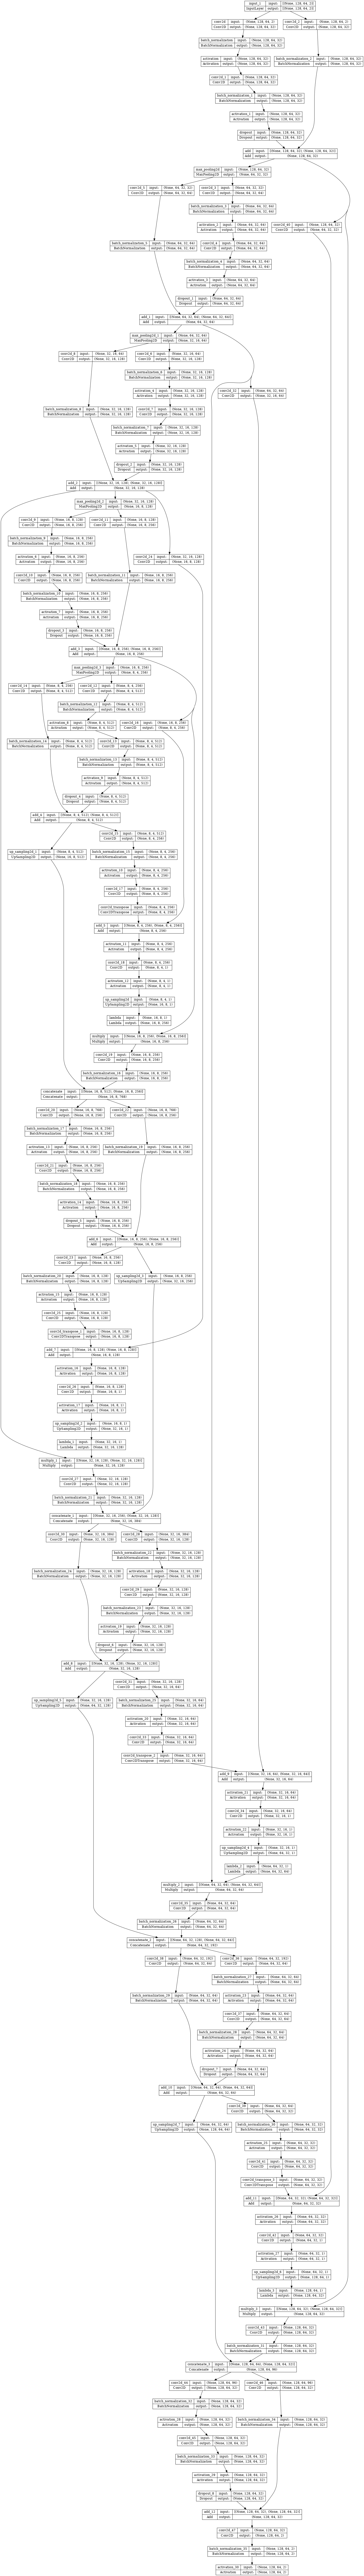

In [16]:
generator = Generator()
tf.keras.utils.plot_model(generator, show_shapes=True, dpi=64)

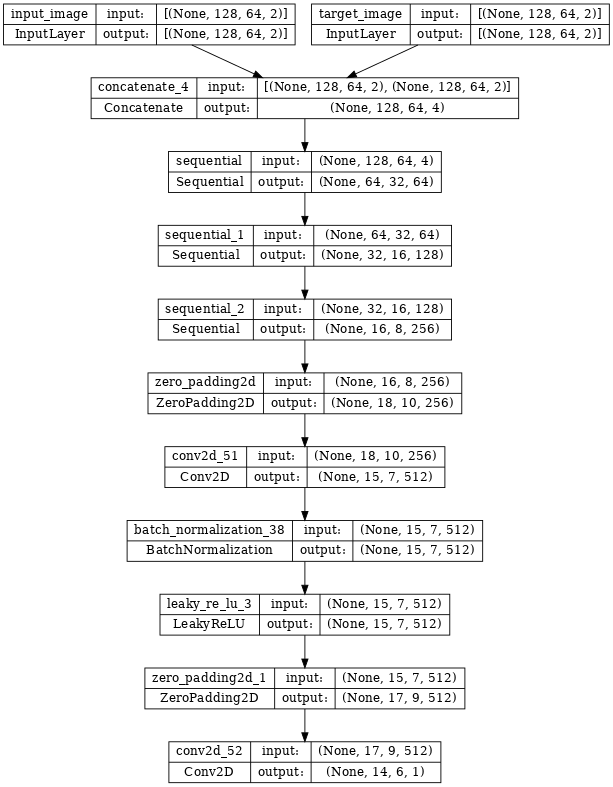

In [17]:
discriminator = Discriminator()
tf.keras.utils.plot_model(discriminator, show_shapes=True, dpi=64)

In [18]:
LAMBDA = 100

# loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)
loss_object = tf.keras.losses.MeanSquaredLogarithmicError()


def generator_loss(disc_generated_output, gen_output, target):
  gan_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)

  # Mean absolute error
  l1_loss = tf.reduce_mean(tf.abs(target - gen_output))
  # mlse_loss = tf.reduce_mean(tf.square(tf.math.log(target + 1) - tf.math.log(gen_output + 1)))

  total_gen_loss = gan_loss + (LAMBDA * l1_loss)

  return total_gen_loss, gan_loss, l1_loss

In [19]:
def discriminator_loss(disc_real_output, disc_generated_output, disc_noise):
  real_loss = loss_object(tf.zeros_like(disc_real_output), disc_real_output)

  # generated_loss = loss_object(tf.zeros_like(disc_generated_output), disc_generated_output)
  generated_loss = loss_object(disc_noise, disc_generated_output)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss

In [20]:
generator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [21]:
checkpoint_dir = './p2p_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

In [22]:
def generate_images(model, test_input, tar):
    prediction = model(test_input, training=True)
    plt.figure(figsize=(22, 7))
    
    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Log Power Spectrum - Som ruidoso', 'Log Power Spectrum - Som original', 'Log Power Spectrum - Som filtrado']
    
    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # Getting the pixel values in the [0, 1] range to plot.
        plt.imshow(10 * np.log10(display_list[i][..., 0]), aspect='auto', cmap='inferno')
        plt.colorbar(format='%+2.0f dB')  # Removi a variável 'im' e 'axs[0]'
        plt.axis('off')
    
    plt.show()

/tmp/ipykernel_3585/1061237556.py:12: RuntimeWarning: invalid value encountered in log10
  plt.imshow(10 * np.log10(display_list[i][..., 0]), aspect='auto', cmap='inferno')


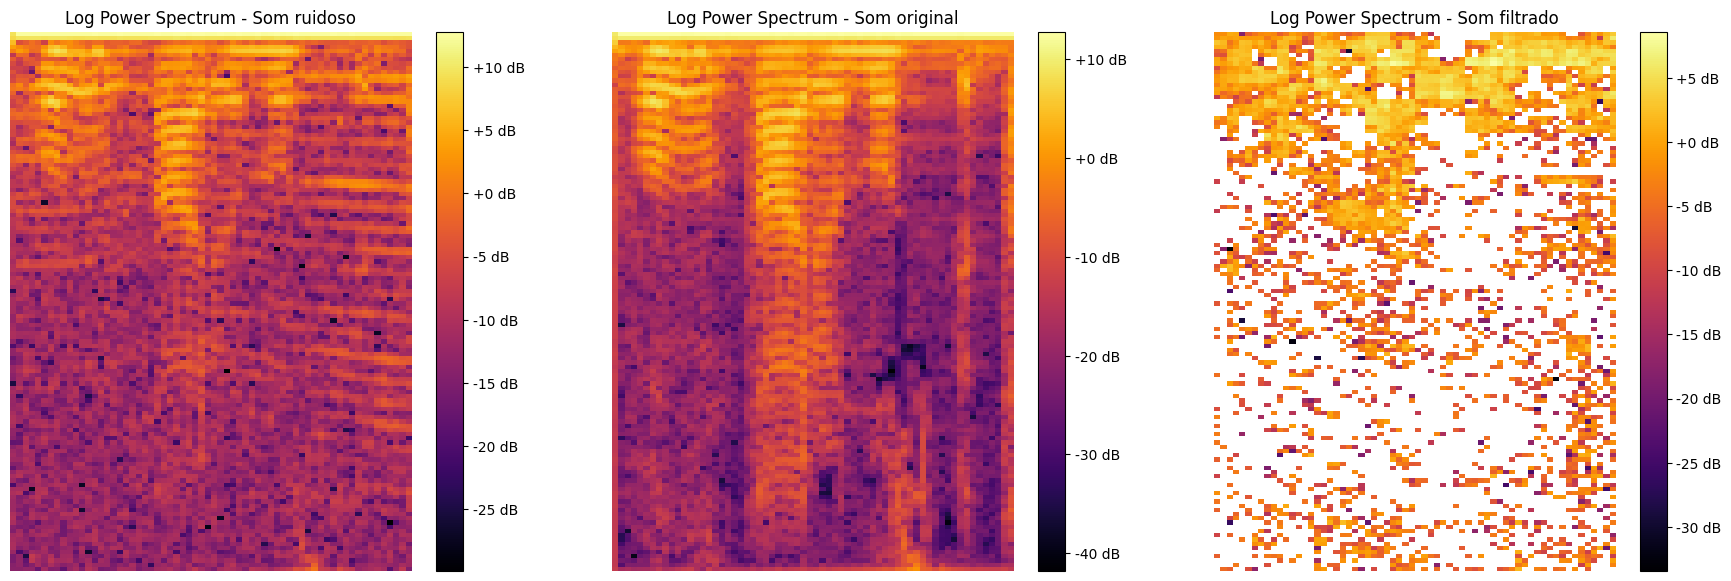

In [23]:
noisy_stft_batch, real_stft_batch = next(data_generator_train.generate_sample_completo(2))
generate_images(generator, noisy_stft_batch, real_stft_batch)

In [24]:
import datetime

In [25]:
log_dir="logs/"

summary_writer = tf.summary.create_file_writer(
  log_dir + "fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [26]:
def calcula_ruido_espectro(input_image, target):
    fasores_ruidoso_real = input_image[..., 0]
    fasores_ruidoso_imag = input_image[..., 1]
    fasores_original_real = target[..., 0]
    fasores_original_imag = target[..., 1]

    fasores_ruido_real = fasores_ruidoso_real * tf.cos(2 * np.pi * (fasores_ruidoso_imag - 0.5))
    fasores_ruido_imag = fasores_ruidoso_imag * tf.sin(2 * np.pi * (fasores_ruidoso_imag - 0.5))

    fasores_ruidoso = tf.complex(fasores_ruido_real, fasores_ruido_imag)
    fasores_original = tf.complex(fasores_original_real, fasores_original_imag)

    fasores_ruido = fasores_ruidoso - fasores_original

    modulo_ruido = tf.abs(fasores_ruido)

    batch_size = input_image.shape[0]
    new_shape = (14, 6)
    modulo_ruido_scaled = tf.TensorArray(dtype=tf.float32, size=batch_size)

    for i in range(batch_size):
        modulo_ruido_scaled_i = zoom(modulo_ruido[i], (new_shape[0] / input_image.shape[1], new_shape[1] / input_image.shape[2]))
        modulo_ruido_scaled_i = tf.where(modulo_ruido_scaled_i <= 0., 0.0001, modulo_ruido_scaled_i)
        modulo_ruido_scaled = modulo_ruido_scaled.write(i, modulo_ruido_scaled_i)

    modulo_ruido_scaled = modulo_ruido_scaled.stack()

    return 10 * tf.math.log(tf.reshape(modulo_ruido_scaled, (*modulo_ruido_scaled.shape, 1))) /  tf.math.log(10.)

In [27]:
def graph(input_image, target, step):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        gen_output = generator(input_image, training=True)
        
        disc_real_output = discriminator([input_image, target], training=True)
        disc_generated_output = discriminator([input_image, gen_output], training=True)

        disc_noise = calcula_ruido_espectro(input_image, gen_output)
        
        gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
        disc_loss = discriminator_loss(disc_real_output, disc_generated_output, disc_noise)

    return gen_tape, gen_total_loss, disc_tape, disc_loss

In [28]:
# @tf.function
def train_step(input_image, target, step):
  # with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
  #   gen_output = generator(input_image, training=True)

  #   disc_real_output = discriminator([input_image, target], training=True)
  #   disc_generated_output = discriminator([input_image, gen_output], training=True)

  #   gen_total_loss, gen_gan_loss, gen_l1_loss = generator_loss(disc_generated_output, gen_output, target)
  #   disc_loss = discriminator_loss(disc_real_output, disc_generated_output)
  gen_tape, gen_total_loss, disc_tape, disc_loss = graph(input_image, target, step)

  generator_gradients = gen_tape.gradient(gen_total_loss,
                                          generator.trainable_variables)
  discriminator_gradients = disc_tape.gradient(disc_loss,
                                               discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(generator_gradients,
                                          generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(discriminator_gradients,
                                              discriminator.trainable_variables))

  # with summary_writer.as_default():
  #   tf.summary.scalar('gen_total_loss', gen_total_loss, step=step // 1000)
  #   tf.summary.scalar('gen_gan_loss', gen_gan_loss, step=step // 1000)
  #   tf.summary.scalar('gen_l1_loss', gen_l1_loss, step=step // 1000)
  #   tf.summary.scalar('disc_loss', disc_loss, step=step // 1000)


In [29]:
def fit(data_generator, steps):
  example_input, example_target = next(data_generator)  # Get an example batch from the generator
  start = time.time()

  for step in tqdm(range(steps)):
    if (step + 1) % 100 == 0:
      display.clear_output(wait=True)

      if step != 0:
        print(f'Time taken for 100 steps: {time.time() - start:.2f} sec\n')

      start = time.time()
      indice_aleatorio = np.random.choice(example_input.shape[0])

      # Selecione a amostra correspondente
      amostra_noisy = example_input[indice_aleatorio]
      amostra_noisy = amostra_noisy[np.newaxis, ...]

      amostra_original = example_target[indice_aleatorio]
      amostra_original = amostra_original[np.newaxis, ...]

      generate_images(generator, amostra_noisy, amostra_original)
      print(f"Step: {step}")

    input_image, target = next(data_generator)  # Get the next batch from the generator
    train_step(input_image, target, step)

    # Training step
    # if (step + 1) % 10 == 0:
    #   print('.', end='', flush=True)

    # Save (checkpoint) the model every 5k steps
    if (step + 1) % 5000 == 0:
      checkpoint.save(file_prefix=checkpoint_prefix)

Time taken for 100 steps: 37.79 sec



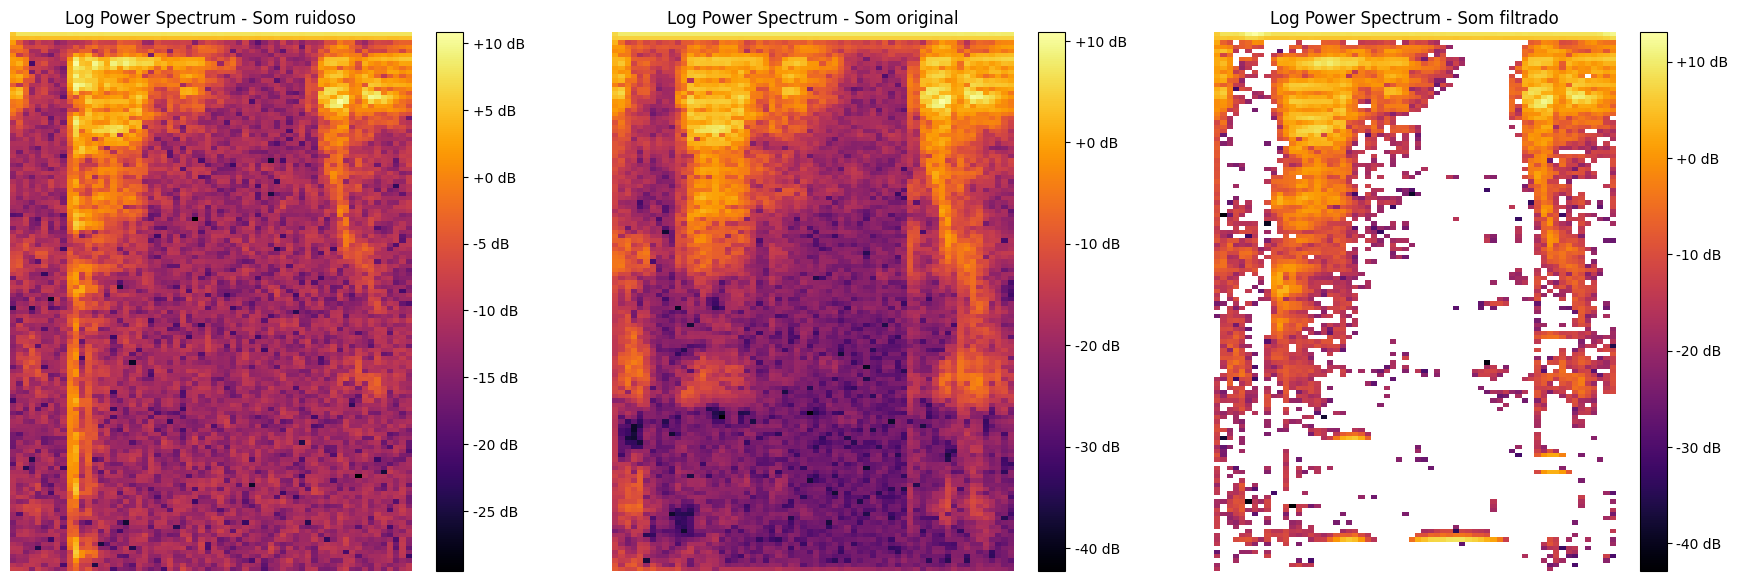

Step: 39999


100%|██████████| 40000/40000 [4:12:06<00:00,  2.64it/s]


In [30]:
fit(data_generator_train.generate_sample_completo(batch_size=16), steps=40000)

In [43]:
x_test, y_test = next(data_generator_train.generate_sample_completo(batch_size=2))

/tmp/ipykernel_3585/1061237556.py:12: RuntimeWarning: invalid value encountered in log10
  plt.imshow(10 * np.log10(display_list[i][..., 0]), aspect='auto', cmap='inferno')


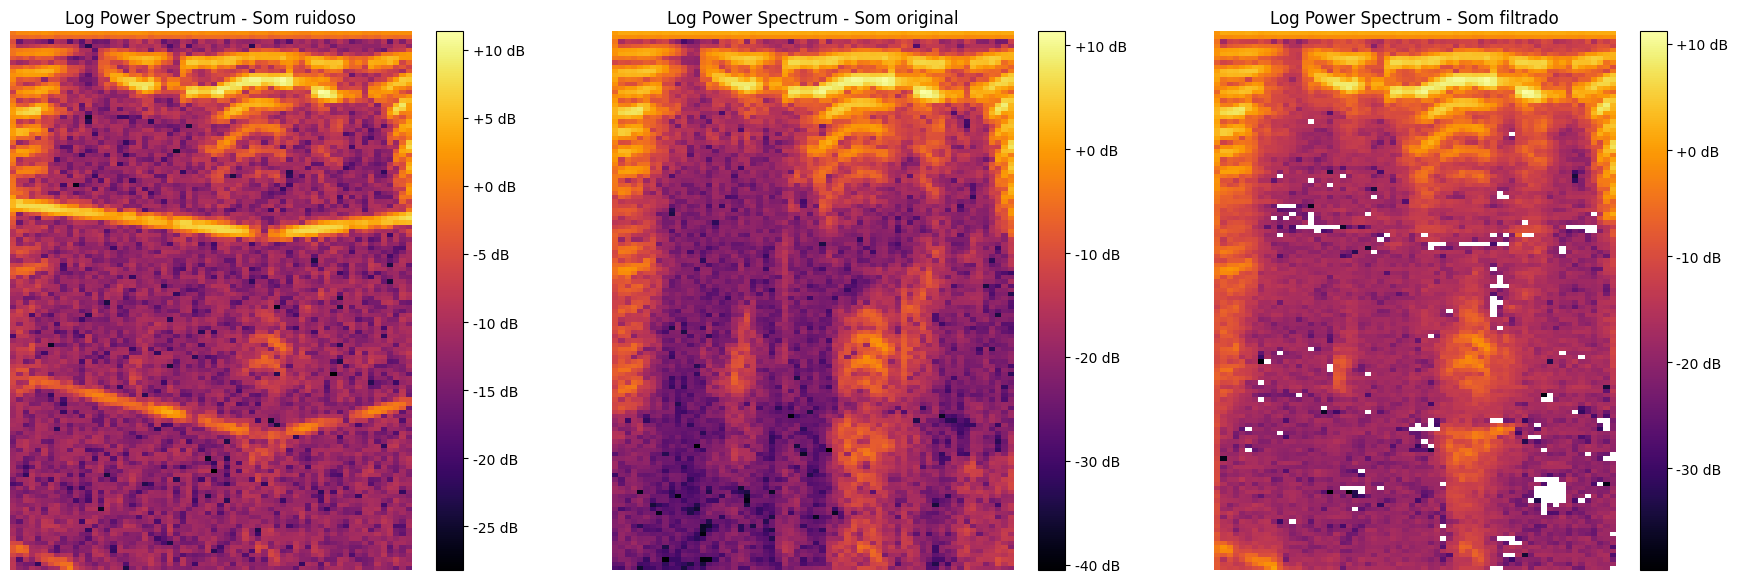

In [44]:
generate_images(generator, x_test, y_test)

In [45]:
F_f = generator.predict(x_test)

1/1 [==============================] - 0s 18ms/step


In [46]:
x_test = x_test[0]
y_test = y_test[0]
F_f = F_f[0]

In [47]:
y_test.shape

(128, 64, 2)

In [48]:
A = y_test[:, :, 0]
phi = (y_test[:, :, 1] - 0.5) * 2 * np.pi

A_f = F_f[:, :, 0]
phi_f = (F_f[:, :, 1] - 0.5) * 2 * np.pi

A_n = x_test[:, :, 0]
phi_n = (x_test[:, :, 1] - 0.5) * 2 * np.pi

In [49]:
s = reconstruct_signal_from_stft(A, phi)
s_n = reconstruct_signal_from_stft(A_n, phi_n)
s_f = reconstruct_signal_from_stft(A_f, phi_f)

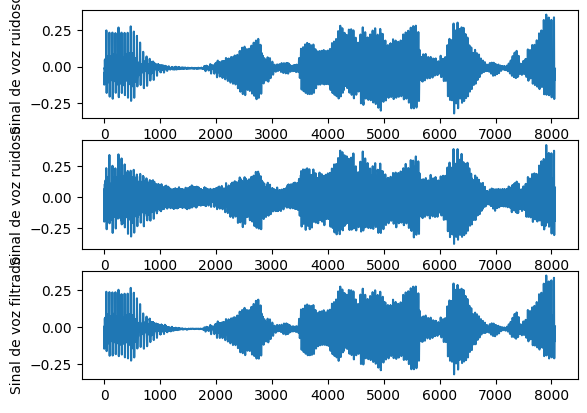

In [50]:
# Criando figuras e eixos separados para cada array
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)

# Plotando o primeiro array
ax1.plot(s)
ax1.set_ylabel('Sinal de voz ruidoso')

# Plotando o primeiro array
ax2.plot(s_n)
ax2.set_ylabel('Sinal de voz ruidoso')

ax3.plot(s_f)
ax3.set_ylabel('Sinal de voz filtrado')

# Exibindo os gráficos
plt.show()

In [51]:
Audio(data=s, rate=8000)

In [52]:
Audio(data=s_n, rate=8000)

In [53]:
Audio(data=s_f, rate=8000)

In [54]:
# Get the current datetime
current_datetime = datetime.datetime.now()

# Format the datetime as a string to use in the file name
datetime_str = current_datetime.strftime("%Y-%m-%d_%H-%M-%S")

generator.save('generator-pix2pix-40000-steps'+datetime_str+'.h5')
discriminator.save('discriminator-pix2pix-40000-steps'+datetime_str+'.h5')

In [2]:
bool(None)

False